In [2]:
##########################################################################
# ADD SOME GENERAL INFO and LICENSE -> @ajay6763
##########################################################################
from __future__ import division
import sys,os,time
import obspy
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.trigger import recursive_sta_lta_py
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import matplotlib.transforms as mtransforms
#import pygmt
import csv
import pandas as pd
import bp_lib
from joblib import Parallel, delayed
import obspy.geodetics
from obspy.signal.cross_correlation import xcorr_pick_correction # for cross-correlation


num_cores = 12
root_order = 2
corr_window=10
snr_window=10
extra_label='_10_sps'

file='input_default.csv'
#file='input_allsta_7.7_anubhab.csv'
#file='input_USA_Turkey_7.7.csv'

input = pd.read_csv('./'+file,header=None)
a=input.to_dict('series')
keys = a[0][:]
values = a[1][:]
res = {}
for i in range(len(keys)):
        res[keys[i]] = values[i]
        #print(keys[i],values[i])

##########################################################################
# Event info

Event=res['Event']
event_lat=float(res['event_lat'])
event_long=float(res['event_long'])
event_depth=float(res['event_depth'])

Array_name=res['Array_name']
azimuth_min=float(res['azimuth_min'])
azimuth_max=float(res['azimuth_max'])
try:
    backazimuth_min=float(res['backazimuth_min'])
    backazimuth_max=float(res['backazimuth_max'])
except:
    pass
dist_min=float(res['dist_min'])
dist_max=float(res['dist_max'])
origin_time=obspy.UTCDateTime(int(res['origin_year']),int(res['origin_month']),
             int(res['origin_day']),int(res['origin_hour']),int(res['origin_minute']),float(res['origin_seconds']))
print(origin_time)

Focal_mech = dict(strike=float(res['event_strike']), dip=float(res['event_dip']), rake=float(res['event_rake'])
                  , magnitude=float(res['event_magnitude']))
stations = str(res['stations'])
waveforms= str(res['waveforms']) 
##########################################################################
# BP parameters
##########################################################################
model               = TauPyModel(model=str(res['model']))
Start_P_cut_time    = float(res['Start_P_cut_time'])  #before P arrival in seconds
End_P_cut_time      = float(res['End_P_cut_time']) #After P arrival seconds
sps                 = float(res['sps'])  #samples per seconds
threshold_correlation=float(res['threshold_correlation'])
SNR=float(res['SNR'])
bp_l                = float(res['bp_l']) #Hz
bp_u                = float(res['bp_u'])   #Hz
stack_start         = int(res['stack_start'])   #in seconds
stack_end           = int(res['stack_end'])  #in seconds
STF_start           = int(res['STF_start'])
STF_end             = int(res['STF_end'])
#smooth_time_window  = int((STF_end-STF_start)/10) #int(res['smooth_time_window'])   #seconds
smooth_time_window  = int(res['smooth_time_window'])   #seconds
smooth_space_window  = int(res['smooth_space_window'])   #seconds
source_grid_size    = float(res['source_grid_size']) #degrees
source_grid_extend  = float(res['source_grid_extend'])   #degrees
source_depth_size   = float(res['source_depth_size']) #km
source_depth_extend = float(res['source_grid_extend']) #km
path = os.getcwd()
#Exp_name=res['Exp_name']
Exp_name=str(Array_name)+'_'+str(event_depth)+'km_'+str(res['model'])+'_'+str(source_grid_size)+'_grid'+str(extra_label)
#outdir = str(Event)+'_'+str(Exp_name)
#print('Working in Exp:',outdir)
#isExist = os.path.exists(outdir)
#if not isExist:
#        print('\n###########################################')
#        print('Output directory does not exist. Making one for you.')
#        print('\n###########################################')
#        os.makedirs(outdir)
#else:
#        print('\n###########################################') 
#        print('Output directory exists. It will be overwritted.')
#        print('\n###########################################')

##########################################################################
# saving the input file 
#with open(outdir+'/'+'input.csv', 'w', newline='') as f:
#    writer = csv.writer(f)
#    for row in res.items():
#        writer.writerow(row)
###########################################################################
#Array_name           = 'AU'
#inv                  = obspy.read_inventory(stations)
stream_orig          = obspy.read(waveforms)
stream_work          = stream_orig.copy()
##########################################################################
# Making potential sources grid
##########################################################################
slong,slat          = bp_lib.make_source_grid(event_long,event_lat,source_grid_extend,source_grid_size)
##########################################################################
# Load stations inventory
##########################################################################
# Loading the station inventory and data for AU network
# Getting stations name, lat, and longs in a list
# This is done to make a lookup such that when I read the traces
# I can figure out the locations of those traces.
# What I do not understand is why the station and event is not
# included into the trace.stats, like we have in sac.
# May be I am missing something when I download or
# there is clever way or function do this.
sta_net             = []
sta_name            = []
sta_lat             = []
sta_long            = []
sta_dist            = []
sta_azimuth         = []
sta_backazimuth     = []
sta_P_arrival_taup  = []
stations = pd.read_csv(stations, sep='|')
sta_net             = list(stations['Net'])
sta_name            = list(stations['Station'])
sta_lat             = list(stations['Latitude'])
sta_long            = list(stations['Longitude'])
sta_dist            = list(stations['Distance'])
sta_azimuth         = list(stations['Azimuth'])
print('Total number of stations:', len(sta_lat))



2023-02-06T01:17:34.900000Z
Total number of stations: 2011


In [3]:

##########################################################################
# reading wavefrom data and assigning station info to them 
# I do this by haveing lists of stations with all the info read and 
# extracted above and then look-up for the station name in the waveform
# and doing the assignment
##########################################################################
# Looping through the network traces and writing 
# station latitude and station longitude 
sta_sps=[]
for t in stream_work:
        sta          = t.stats.station
        #net 
        if sta in sta_name:
            ind                          = sta_name.index(sta)
            t.stats['Dist']              = sta_dist[ind]
            t.stats['Azimuth']           = sta_azimuth[ind]
            # theoretical backazimuth and distance
            #baz = gps2dist_azimuth(event_lat, event_long,sta_lat[ind], sta_long[ind])
            #t.stats['Backazimuth']       =  baz[2]
            t.stats['station_latitude']  = sta_lat[ind]
            t.stats['station_longitude'] = sta_long[ind]
            t.stats['origin_time']       = origin_time
            #arrivals                     = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=locations2degrees(event_lat,event_long,sta_lat[ind],sta_long[ind]),phase_list=["P"])
            arrivals                     = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=t.stats.Dist,phase_list=["P"])
            arr                          = arrivals[0]
            t_travel                     = arr.time;
            t.stats['P_arrival']         = origin_time + t_travel 
            sta_sps.append(t.stats.sampling_rate)
        else:
            stream_work.remove(t)
print("Total no stations with data:", len(stream_work))
print("Sampling rate of the waveform data:", np.unique(sta_sps))
################################
## Bound selection
################################
## Bound selection
##########################################################################
# SPS and distance check and azimuth
print('Total no of traces before decimation criteria:', len(stream_work))
stream_work = bp_lib.check_sps(stream_work,sps)
print('Total no of traces after decimation criteria:', len(stream_work))
##########################################################################
# CUtting before and after P arrival 
##########################################################################
print('Total no of traces before data gap checks:', len(stream_work))
stream_work=bp_lib.stream_cut_P_arrival(stream_work,Start_P_cut_time,End_P_cut_time)
print('Total no of traces after cutting and data gap checks ', len(stream_work))

#stream_for_bp = bp_lib.snr_check(stream_cut,2,5,50)
#print('Total no of traces after cutting and data gap checks and final no of traces for bp:', len(stream_work))
#print('Total no of traces before  SNR criteria:', len(stream_work))
#stream_cut_SNR = bp_lib.snr_check(stream_cut,SNR,snr_window,snr_window)
#print('Total no of traces after SNR criteria:', len(stream_cut_S ))
#stream_for_bp=stream_cut_SNR.copy()


Total no stations with data: 1705
Sampling rate of the waveform data: [ 1. 10. 20. 40. 50.]
Total no of traces before decimation criteria: 1705
Total no of traces after decimation criteria: 934
Total no of traces before data gap checks: 934
Total no of traces before data gap checks: 934
Total no of traces after cutting and data gap checks  904


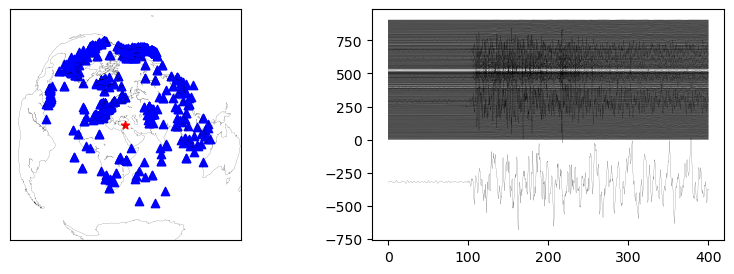

In [4]:
import bp_lib as bp_lib
bp_lib.data_plot(stream_work,event_lat,event_long,'./','test')

In [22]:
from mpl_toolkits.basemap import Basemap
def array_selection_plot(stream,event_lat,event_long,az_min,az_max,dist_min=0,dist_max=90,bp_l=0.1,
                        bp_h=2.0,max_lag=1,SNR_window=10,time_before=5,time_after=100,corr_thresh=0.7,
                         t_plot_start=-20,t_plot_end=100,SNR=2.0):
    fig, ax = plt.subplots(1, 2, sharex=False, sharey=False,figsize=(10,3))
    #map =  Basemap(projection='cyl', lon_0=event_long,lat_0=event_lat,
    #        resolution='c',ax=ax[0])
    width = 28e6
    #map = Basemap(width=width,height=width,projection='aeqd',lon_0=event_long,lat_0=event_lat,resolution='c',ax=ax[1])
    map = Basemap(ax=ax[0],width=width,height=width,projection='aeqd',lon_0=event_long,lat_0=event_lat,resolution='c')
    stream_sorted=bp_lib.check_distance(stream,dist_min,dist_max)
    stream_sorted=bp_lib.check_azimuth(stream_sorted,az_min,az_max)
    stream_sorted=bp_lib.detrend_normalize_stream(stream_sorted,type='demean')
    stream_sorted= bp_lib.snr_check(stream_sorted,SNR,SNR_window,SNR_window)

    #strea_out=stream_sorted.copy()
    Ref_trace_ind =bp_lib.get_ref_station(stream_sorted)
    ref_trace=stream_sorted[Ref_trace_ind]
    #for tr in stream_sorted:
    #    tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
    
    #stream_sorted=bp_lib.crosscorr_stream_xcorr(stream_sorted,ref_trace,Start_P_cut_time,time_before,time_after,max_lag,bp_l,bp_u,corr_thresh)
    stream_sorted=bp_lib.crosscorr_stream_xcorr_no_filter_P_arrival(stream_sorted,ref_trace,time_before,
                                                          time_after,max_lag,corr_thresh)
    #stream_sorted=bp_lib.crosscorr_stream_xcorr_P_arrival(stream_sorted,ref_trace,time_before,
    #                                                      time_after,max_lag,bp_l,bp_h,corr_thresh)
    #stream_sorted=bp_lib.crosscorr_stream_prev(stream_sorted,ref_trace,max_lag,corr_thresh)
    count=0
    for tr_ in stream_sorted:
        count=count+1
        tr=tr_.copy()
        #tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)    # turn this on for filtering to happen
        tr.detrend(type='demean')
        if tr.stats.station == ref_trace.stats.station:
            map.scatter(tr.stats.station_longitude,tr.stats.station_latitude,latlon=True,facecolor='blue',marker='^')
            time = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
            #tr.plot(starttime=t.stats.P_arrival-30,endtime=t.stats.P_arrival+60,type='relative')
            #tr.plot(type='relative')
            #tr.normalize()
            #cut = tr.data  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            temp = tr.trim(tr.stats['P_arrival']-t_plot_start+tr.stats['Corr_shift'],
                          tr.stats['P_arrival']+t_plot_end)  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            temp.normalize()
            cut=temp.data
            cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            #cut=cut/np.max(cut) #+ count
            #cut=cut +count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            ax[1].plot(time,cut*1,color='red',linewidth=0.8)
            #ax[1].plot(time,tr.data,color='gray')
        else:
            map.scatter(tr.stats.station_longitude,tr.stats.station_latitude,latlon=True,facecolor='blue',marker='^')
            time = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
            #tr.plot(starttime=t.stats.P_arrival-30,endtime=t.stats.P_arrival+60,type='relative')
            #tr.plot(type='relative')
            #tr.normalize()
            #cut = tr.data  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            temp = tr.trim(tr.stats['P_arrival']-t_plot_start+tr.stats['Corr_shift'],
                           tr.stats['P_arrival']+t_plot_end)  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            temp.normalize()
            cut=temp.data
            cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            #cut=cut/np.max(cut) #+ count
            #cut=cut +count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            ax[1].plot(time,cut*1,color='grey',linewidth=0.5)
            #ax[1].plot(time,tr.data,color='gray')
    map.scatter(event_long,event_lat,latlon=True,facecolor='red',marker='*')
    map.drawcoastlines(linewidth=0.1)
    x, y = map(event_long, event_lat)
    print('Total traces:',len(stream_sorted))
    #focmecs = Focal_mech
    #ax = plt.gca()
    #b = beach(focmecs, xy=(x, y), width=10, linewidth=1, alpha=0.85)
    #b.set_zorder(10000000)
    #ax.add_collection(b)
    ## plot traces
    plt.show()
    #fig.savefig(outdir+'/'+outname)
    return stream_sorted

In [23]:
stream_test=stream_work.copy()


/home/ajay/miniforge/lib/python3.10/site-packages/obspy/core/trace.py:2246: UserWarning: Attempting to normalize by dividing through zero. This is not allowed and the data will thus not be changed.
  warnings.warn(msg)
/home/shubham/anubhab_iiserk/codes/earthquake_bp_obspy_dev/earthquake_bp_obspy/bp_lib.py:826: RuntimeWarning: invalid value encountered in scalar divide
  snr=signal_amp/noise_amp


Total traces: 191


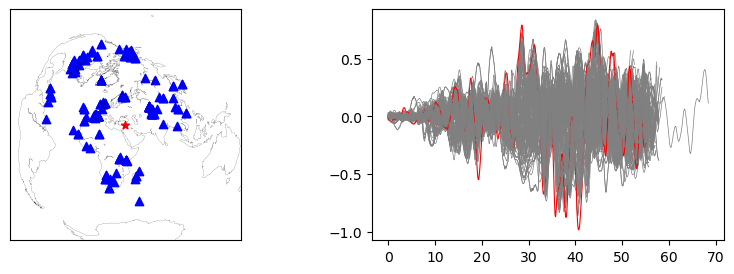

In [43]:
#all stations, maximum possible
az_min=-180
az_max=180
dist_min=30 #30
dist_max=95
stream_sorted=array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.8,bp_h=2.5,SNR_window=20,max_lag=20,time_before=20,time_after=20,
                     corr_thresh=0.4,t_plot_start=5,
                     t_plot_end=50,SNR=4)

#arguments for 191 stations around the world - SNR=4, corr_threshold=0.4.

/home/ajay/projects/pyrocko/seis_python/lib64/python3.9/site-packages/obspy/core/trace.py:2245: UserWarning: Attempting to normalize by dividing through zero. This is not allowed and the data will thus not be changed.
  warnings.warn(msg)
/home/ajay/projects/seismology/earthquake_bp_obspy/bp_lib.py:826: RuntimeWarning: invalid value encountered in scalar divide
  snr=signal_amp/noise_amp


Total traces: 29


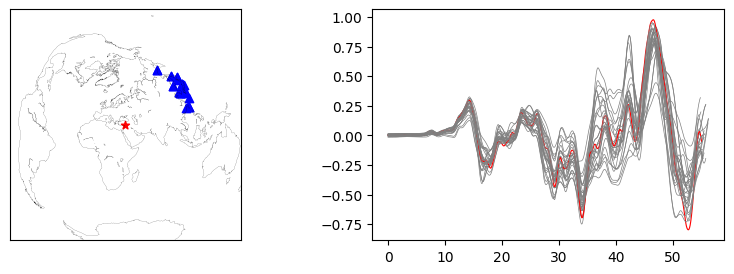

In [185]:
#JP
az_min=20
az_max=80
dist_min=60 #30
dist_max=90
stream_sorted=array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.01,bp_h=1,SNR_window=20,max_lag=20,time_before=20,time_after=20,
                     corr_thresh=0.6,t_plot_start=5,
                     t_plot_end=50,SNR=10)


Total traces: 68


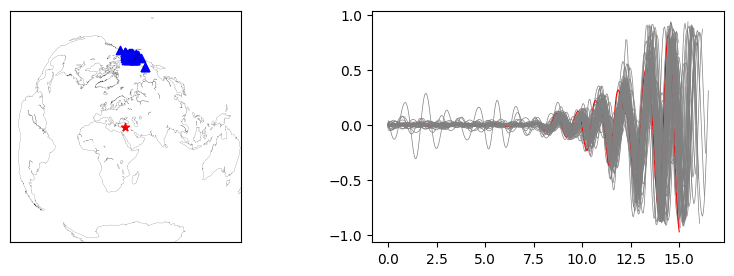

In [162]:
#USA
az_min=-25
az_max=25
dist_min=60 #30
dist_max=90
stream_sorted=array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.85,bp_h=5,SNR_window=20,max_lag=20,time_before=20,time_after=20,
                     corr_thresh=0.6,t_plot_start=5,
                     t_plot_end=10,SNR=10)


In [75]:
bp_l=0.1
bp_u=0.5
ref_trace=stream_sorted[1]
tr=stream_sorted[20]
time_before=10
time_after=20
max_lag=10
ref_trace.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
shift, value = xcorr_pick_correction(ref_trace.stats.starttime+Start_P_cut_time, ref_trace,tr.stats.starttime+Start_P_cut_time, tr,
                t_before=time_before, t_after=time_after, cc_maxlag=max_lag,plot=True)#,filter="bandpass",filter_options={'freqmin': bp_l, 'freqmax': bp_u})
print(shift,value)

IndexError: list index out of range

/home/ajay/projects/pyrocko/seis_python/lib64/python3.9/site-packages/obspy/core/trace.py:2245: UserWarning: Attempting to normalize by dividing through zero. This is not allowed and the data will thus not be changed.
  warnings.warn(msg)
/home/ajay/projects/earthquake_bp_obspy/bp_lib.py:801: RuntimeWarning: invalid value encountered in scalar divide
  snr=signal_amp/noise_amp


Total traces: 190


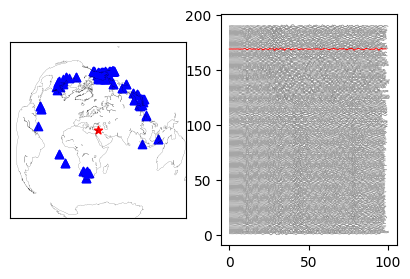

In [45]:
#all
az_min=-180
az_max=180
dist_min=60 #30
dist_max=90
stream_sorted=array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.2,bp_h=2,max_lag=10,time_before=10,time_after=10,
                     corr_thresh=0.5,t_plot_start=-1,
                     t_plot_end=100,SNR=3)



Total traces: 29


/home/ajay/projects/pyrocko/seis_python/lib64/python3.9/site-packages/obspy/core/trace.py:2245: UserWarning: Attempting to normalize by dividing through zero. This is not allowed and the data will thus not be changed.
  warnings.warn(msg)
/home/ajay/projects/earthquake_bp_obspy/bp_lib.py:801: RuntimeWarning: invalid value encountered in scalar divide
  snr=signal_amp/noise_amp


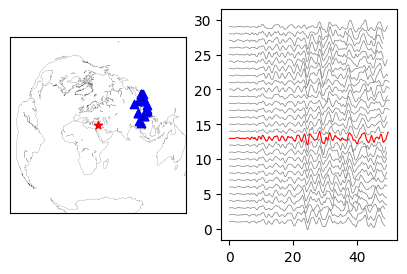

In [38]:
#JP
az_min=50
az_max=90
dist_min=50 #30
dist_max=90
stream_sorted=array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.2,bp_h=2.2,max_lag=10,time_before=10,time_after=10,
                     corr_thresh=0.8,t_plot_start=0,
                     t_plot_end=50,SNR=3)



In [23]:
#crosscorr_template(stream_sorted[1],stream_sorted[2],10)
cc=obspy.signal.cross_correlation.correlate_template(stream_sorted[1],stream_sorted[2],demean=True,
                                                         normalize='full',method='auto')
    
shift, value = obspy.signal.cross_correlation.xcorr_max(cc)
    

In [24]:
cc

array([0.07866854])

Total traces: 1


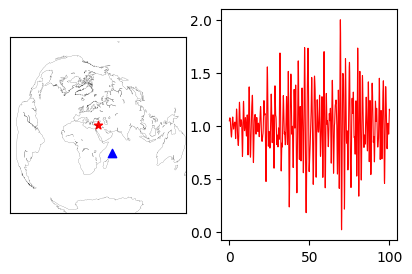

In [18]:
#Australia
az_min=120
az_max=160
dist_min=45 #30
dist_max=80
stream_out=array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.5,bp_h=2,max_lag=10,time_before=10,time_after=20,
                     corr_thresh=0.2,t_plot_start=0,
                     t_plot_end=100,SNR=4)

Total traces: 26


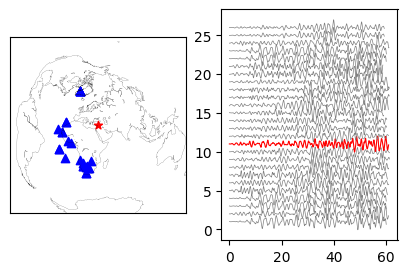

26 Trace(s) in Stream:

DK.SFJD.00.BHZ | 2023-02-06T01:25:28.369538Z - 2023-02-06T01:32:08.369538Z | 20.0 Hz, 8001 samples
...
(24 other traces)
...
G.SOK.10.BHZ | 2023-02-06T01:25:07.300000Z - 2023-02-06T01:31:47.300000Z | 20.0 Hz, 8001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [28]:
#EU
az_min=-180 #118
az_max=-25 #160
dist_min=45 #45
dist_max=80 #80
array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.5,bp_h=2.5,max_lag=10,time_before=10,time_after=10,
                     corr_thresh=0.6,t_plot_start=1,
                     t_plot_end=60,SNR=2)

Total traces: 5


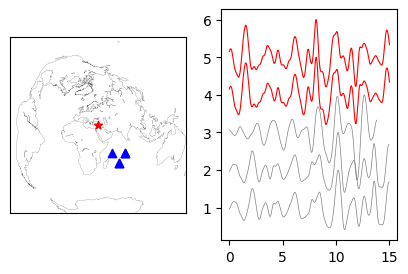

5 Trace(s) in Stream:
II.DGAR.00.BHZ | 2023-02-06T01:25:30.519536Z - 2023-02-06T01:32:10.519536Z | 20.0 Hz, 8001 samples
II.DGAR.10.BHZ | 2023-02-06T01:25:30.519538Z - 2023-02-06T01:32:10.519538Z | 20.0 Hz, 8001 samples
II.MSEY.10.BHZ | 2023-02-06T01:24:12.769539Z - 2023-02-06T01:30:52.769539Z | 20.0 Hz, 8001 samples
G.ROCAM.00.BHZ | 2023-02-06T01:26:16.250000Z - 2023-02-06T01:32:56.250000Z | 20.0 Hz, 8001 samples
G.ROCAM.10.BHZ | 2023-02-06T01:26:16.250000Z - 2023-02-06T01:32:56.250000Z | 20.0 Hz, 8001 samples

In [30]:
#Australia
az_min=120
az_max=160
dist_min=45 #30
dist_max=80
array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.5,bp_h=2.5,max_lag=10,time_before=10,time_after=10,
                     corr_thresh=0.6,t_plot_start=5,
                     t_plot_end=10,SNR=2)

Total traces: 27


/home/ajay/projects/earthquake_bp_obspy/bp_lib.py:924: UserWarning: Residual in quadratic fit to cross correlation maximum larger than 0.1: [0.12981806]
  warnings.warn(msg)


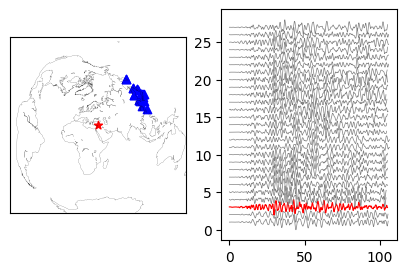

27 Trace(s) in Stream:

IC.MDJ.00.BHZ | 2023-02-06T01:26:44.426672Z - 2023-02-06T01:33:24.426672Z | 20.0 Hz, 8001 samples
...
(25 other traces)
...
G.INU.00.BHZ | 2023-02-06T01:27:43.811303Z - 2023-02-06T01:34:23.811303Z | 20.0 Hz, 8001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [34]:
#USA
az_min=10
az_max=80
dist_min=60 #30
dist_max=90
array_selection_plot(stream_test,event_lat,event_long,az_min,az_max,dist_min,dist_max,
                    bp_l=0.25,bp_h=2.5,max_lag=10,time_before=10,time_after=10,
                     corr_thresh=0.8,t_plot_start=5,
                     t_plot_end=100,SNR=2)


D:\Work\tools\earthquake_bp_obspy\bp_lib.py:405: RuntimeWarning: invalid value encountered in scalar divide
  x_centroid = x_sum / n
D:\Work\tools\earthquake_bp_obspy\bp_lib.py:406: RuntimeWarning: invalid value encountered in scalar divide
  y_centroid = y_sum / n


ValueError: attempt to get argmin of an empty sequence

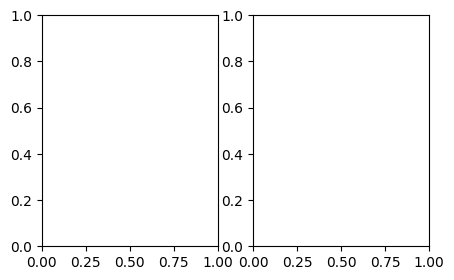

In [128]:
az_min=40
az_max=90
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

D:\Work\tools\earthquake_bp_obspy\bp_lib.py:733: UserWarning: Artifacts from signal processing possible. Trace 0 should have more additional data at the start.
  warnings.warn(msg)
D:\Work\tools\earthquake_bp_obspy\bp_lib.py:733: UserWarning: Artifacts from signal processing possible. Trace 1 should have more additional data at the start.
  warnings.warn(msg)
D:\Work\tools\earthquake_bp_obspy\bp_lib.py:777: UserWarning: Fitting at maximum lag. Maximum lag time should be increased.
  warnings.warn(msg)
D:\Work\tools\earthquake_bp_obspy\bp_lib.py:787: UserWarning: Less than 5 samples selected for fit to cross correlation: 4
  warnings.warn(msg)
D:\Work\tools\earthquake_bp_obspy\bp_lib.py:787: UserWarning: Less than 5 samples selected for fit to cross correlation: 3
  warnings.warn(msg)


Could not cross-correlate! Hence remove this waveform.
Could not cross-correlate! Hence remove this waveform.
Could not cross-correlate! Hence remove this waveform.
Could not cross-correlate! Hence remove this waveform.
Could not cross-correlate! Hence remove this waveform.
Could not cross-correlate! Hence remove this waveform.


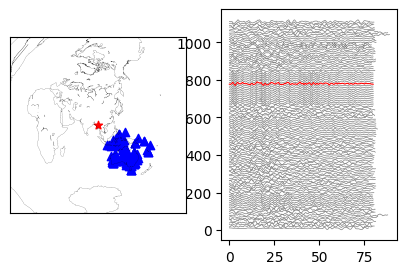

In [129]:
az_min=90
az_max=160
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

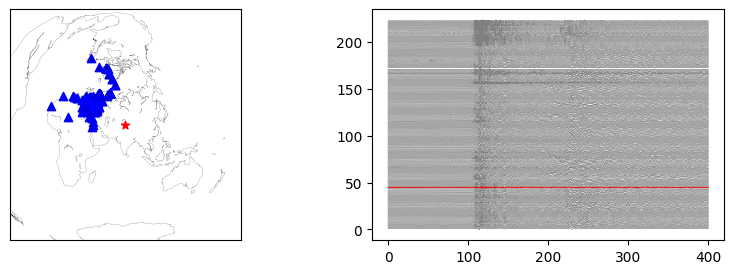

In [29]:
az_min=-120
az_max=0
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

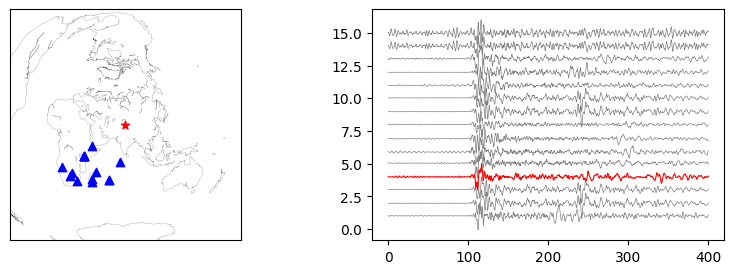

In [30]:
az_min=-179
az_max=-120
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

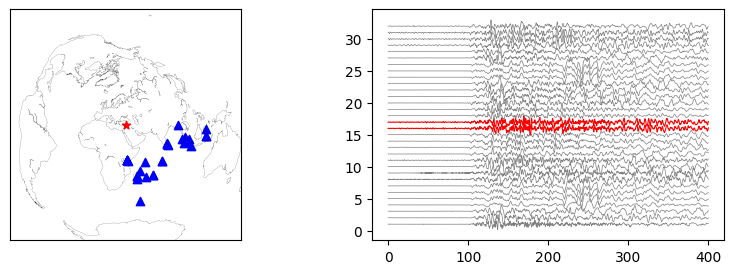

In [44]:
az_min=90
az_max=180
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

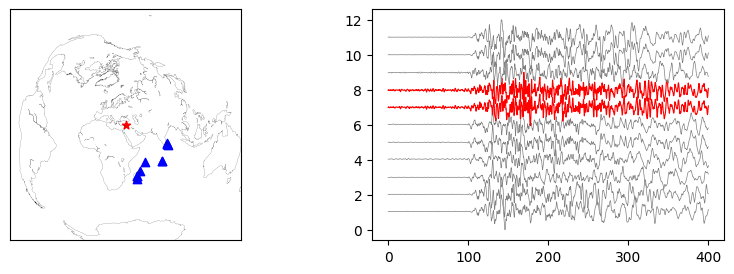

In [41]:
az_min=100
az_max=170
dist_min=30
dist_max=60
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

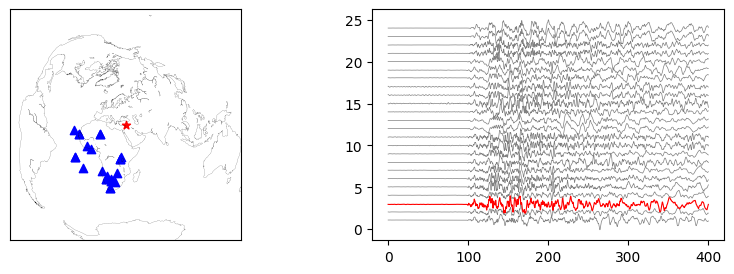

In [42]:
az_min=-179
az_max=-90
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

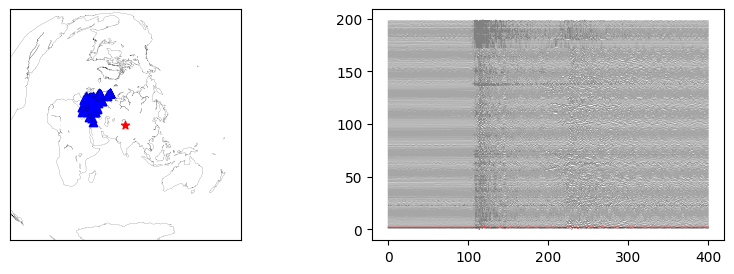

In [31]:
az_min=-90
az_max=-20
dist_min=35
dist_max=60
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

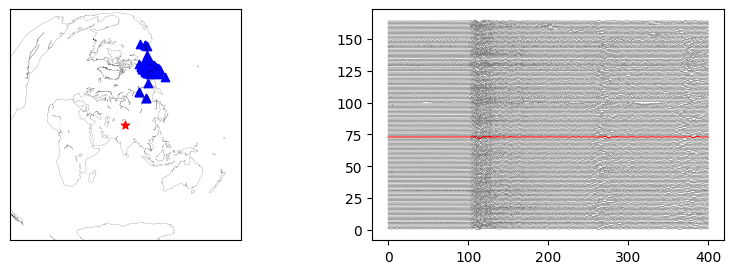

In [148]:
az_min=-10
az_max=40
dist_min=30
dist_max=90
array_selection_plot(stream_for_bp,event_lat,event_long,az_min,az_max,dist_min,dist_max)

In [23]:
az=[]
baz=[]
for t in stream_work:
    az.append(t.stats.Azimuth)
    baz.append(t.stats.Backazimuth)

In [6]:
stream_stack=stream_for_bp.copy()
st=stream_stack.stack('linear')

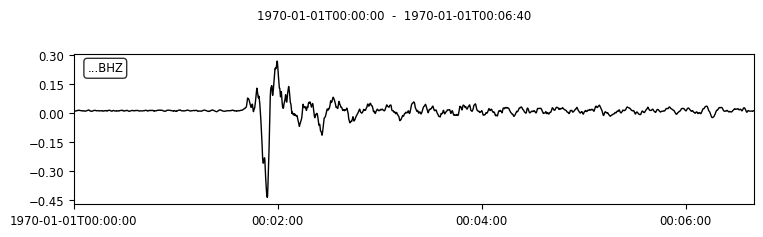

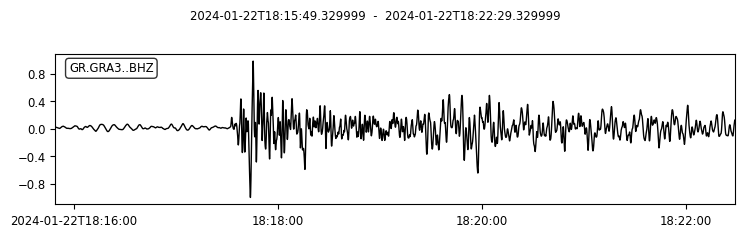

In [7]:
st.plot();
t=stream_for_bp[10]
t.plot();

          network: GR
          station: GRA3
         location: 
          channel: BHZ
        starttime: 2024-01-22T18:15:49.329999Z
          endtime: 2024-01-22T18:22:29.329999Z
    sampling_rate: 10.0
            delta: 0.1
             npts: 4001
            calib: 1.0
          Azimuth: -55.50818762435577
             Dist: 46.32020828683203
        P_arrival: 2024-01-22T18:17:29.372930Z
          _format: MSEED
            mseed: AttribDict({'dataquality': 'D', 'number_of_records': 58, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 44402688})
      origin_time: 2024-01-22T18:09:04.000000Z
       processing: ["ObsPy 1.4.0: resample(no_filter=True::sampling_rate=10.0::strict_length=False::window='hann')", 'ObsPy 1.4.0: trim(endtime=UTCDateTime(2024, 1, 22, 18, 22, 29, 372930)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2024, 1, 22, 18, 15, 49, 372930))', 'ObsPy 1.4.0: normalize(norm=None)']
 station_latitude: 49.761076
stati

(-90.0, 90.0)

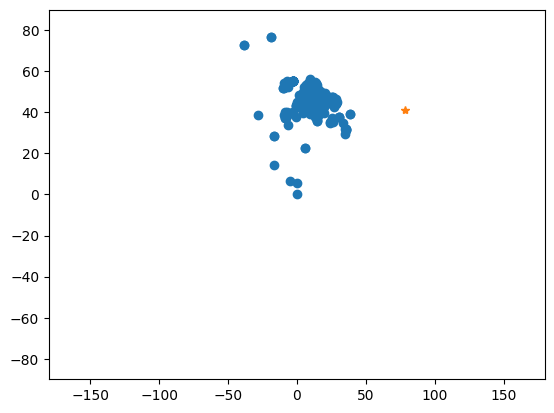

In [24]:
baz_min=45
baz_max=80
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Backazimuth >= baz_min and t.stats.Backazimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)

(-90.0, 90.0)

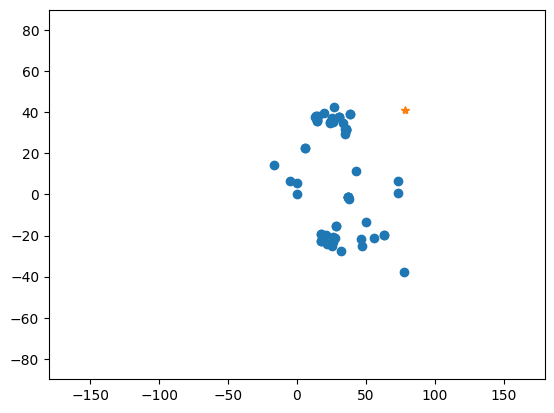

In [16]:
baz_min=-180
baz_max=-70
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Azimuth >= baz_min and t.stats.Azimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)

(-90.0, 90.0)

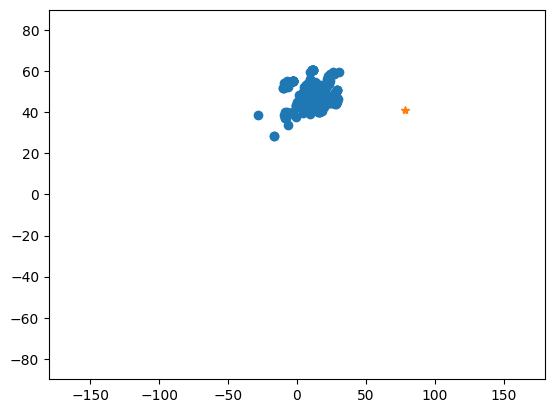

In [17]:
baz_min=-70
baz_max=-40
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Azimuth >= baz_min and t.stats.Azimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)

(-90.0, 90.0)

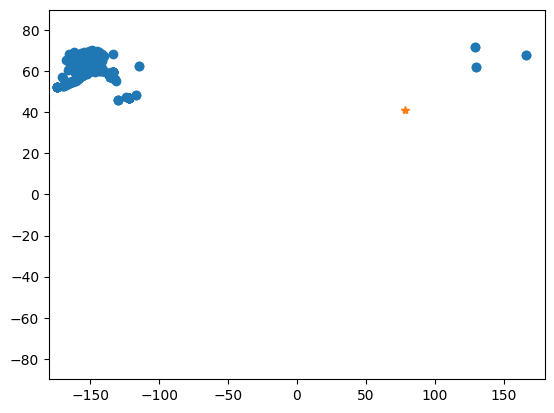

In [20]:
baz_min=-10
baz_max=40
lat=[]
long=[]
stream_temp=stream_work.copy()
for t in stream_temp:
    if (t.stats.Azimuth >= baz_min and t.stats.Azimuth <= baz_max):
        lat.append(t.stats.station_latitude)
        long.append(t.stats.station_longitude)
    else:
        pass
        #stream_temp.remove(t)
plt.plot(long,lat,'o')
plt.plot(event_long,event_lat,'*')
plt.xlim(-180,180)
plt.ylim(-90,90)